<a href="https://colab.research.google.com/github/randy-tsukemen/Data_science_roadmap/blob/master/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Customer Segmentation

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import datetime as dt



##  Cohort Analysis

What is Cohort Analysis?
- Mutually exclusive segments - cohorts
- Compare metrics across product lifecycle
- Compare metrics across customer lifecycle

Types of cohorts
- Time cohorts
- Behavior cohorts
- Size cohorts

Elements of cohort analysis
- Pivot table
- Assigned cohort in rows
- Cohort Index in columns
- Metrics in the table

Assign daily acquisition cohort

As you have seen in the video, defining a cohort is the first step to cohort analysis. You will now create daily cohorts based on the day each customer has made their first transaction.

The data has been loaded as online DataFrame, you can now print its header with online.head() in the console.

In [2]:
!wget https://assets.datacamp.com/production/repositories/3202/datasets/40378e0b8f88bffddc938f335bc68baa8fdf0b18/chapter_1.zip

--2020-06-10 02:36:33--  https://assets.datacamp.com/production/repositories/3202/datasets/40378e0b8f88bffddc938f335bc68baa8fdf0b18/chapter_1.zip
Resolving assets.datacamp.com (assets.datacamp.com)... 13.226.46.120, 13.226.46.10, 13.226.46.129, ...
Connecting to assets.datacamp.com (assets.datacamp.com)|13.226.46.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2103781 (2.0M)
Saving to: ‘chapter_1.zip.1’

chapter_1.zip.1     100%[===================>]   2.01M  12.3MB/s    in 0.2s    

2020-06-10 02:36:33 (12.3 MB/s) - ‘chapter_1.zip.1’ saved [2103781/2103781]



In [3]:
# load data
# ['online.csv', '__MACOSX/', '__MACOSX/._online.csv', 'cohort_counts.csv', '__MACOSX/._cohort_counts.csv', 'average_quantity.csv', '__MACOSX/._average_quantity.csv']

zf = zipfile.ZipFile('chapter_1.zip') 
online = pd.read_csv(zf.open('online.csv'), index_col=0)
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom
263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom
495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom
204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom


Now each customer belongs to a daily acquisition cohort that you can use for further analysis!

In [4]:
# Define a function that will parse the date
def get_day(x): return dt.datetime(x.year, x.month, x.day) 

# Create InvoiceDay column
online['InvoiceDate'] = pd.to_datetime(online['InvoiceDate'])
online['InvoiceDay'] = online['InvoiceDate'].apply(get_day) 

# Group by CustomerID and select the InvoiceDay value
grouping = online.groupby('CustomerID')['InvoiceDay'] 

# Assign a minimum InvoiceDay value to the dataset
online['CohortDay'] = grouping.transform('min')

# View the top 5 rows
print(online.head())

        InvoiceNo StockCode  ... InvoiceDay  CohortDay
416792     572558     22745  ... 2011-10-25 2011-04-11
482904     577485     23196  ... 2011-11-20 2011-09-12
263743     560034     23299  ... 2011-07-14 2011-07-14
495549     578307    72349B  ... 2011-11-23 2011-11-23
204384     554656     21756  ... 2011-05-25 2011-02-25

[5 rows x 10 columns]


Calculate time offset in days - part 1

Calculating time offset for each transaction allows you to report the metrics for each cohort in a comparable fashion. 

Now you will use these integer values to calculate business metrics for our time cohorts!

In [0]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

# Get the integers for date parts from the `InvoiceDay` column
invoice_year, invoice_month, invoice_day = get_date_int(online, 'InvoiceDay')

# Get the integers for date parts from the `CohortDay` column
cohort_year, cohort_month, cohort_day = get_date_int(online, 'CohortDay')

Calculate time offset in days - part 2

Great work! Now, we have six different data sets with year, month and day values for Invoice and Cohort dates - invoice_year, cohort_year, invoice_month, cohort_month, invoice_day, and cohort_day.

You have successfully assigned the daily time offset to each transaction and can use it for running daily cohort analysis!

In [6]:
# Calculate difference in years
years_diff = invoice_year - cohort_year

# Calculate difference in months
months_diff = invoice_month - cohort_month

# Calculate difference in days
days_diff = invoice_day - cohort_day

# Extract the difference in days from all previous values
online['CohortIndex'] = years_diff * 365 + months_diff * 30 + days_diff + 1
print(online.head())

        InvoiceNo StockCode  ...  CohortDay  CohortIndex
416792     572558     22745  ... 2011-04-11          195
482904     577485     23196  ... 2011-09-12           69
263743     560034     23299  ... 2011-07-14            1
495549     578307    72349B  ... 2011-11-23            1
204384     554656     21756  ... 2011-02-25           91

[5 rows x 11 columns]


Retention gives you the percentage of active customers compared to the total number of customers.

Calculate retention rate from scratch

In [0]:
online['CohortMonth']  =  online['CohortDay'].values.astype('datetime64[M]')
online['CohortIndex'] = years_diff * 12 + months_diff + 1
grouping = online.groupby(['CohortMonth', 'CohortIndex'])
# Count the number of unique values per customer ID
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()

# Create a pivot 
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

# Select the first column and store it to cohort_sizes
cohort_sizes = cohort_counts.iloc[:,0]

# Divide the cohort count by cohort sizes along the rows
retention = cohort_counts.divide(cohort_sizes, axis=0)

In [8]:
retention

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,1.0,0.343575,0.308659,0.350559,0.342179,0.398045,0.347765,0.329609,0.335196,0.370112,0.354749,0.486034,0.240223
2011-01-01,1.0,0.207831,0.246988,0.243976,0.331325,0.271084,0.246988,0.259036,0.313253,0.307229,0.373494,0.135542,NaN
2011-02-01,1.0,0.183544,0.180380,0.262658,0.268987,0.234177,0.253165,0.262658,0.272152,0.300633,0.088608,NaN,NaN
2011-03-01,1.0,0.162371,0.257732,0.195876,0.213918,0.172680,0.252577,0.219072,0.275773,0.097938,NaN,NaN,NaN
2011-04-01,1.0,0.192157,0.203922,0.192157,0.184314,0.203922,0.219608,0.231373,0.066667,NaN,NaN,NaN,NaN
2011-05-01,1.0,0.160643,0.172691,0.144578,0.208835,0.232932,0.244980,0.088353,NaN,NaN,NaN,NaN,NaN
2011-06-01,1.0,0.159420,0.125604,0.198068,0.236715,0.299517,0.091787,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,1.0,0.161850,0.179191,0.219653,0.254335,0.098266,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,1.0,0.215827,0.201439,0.251799,0.100719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Calculate average price

You will now calculate the average price metric and analyze if there are any differences in shopping patterns across time and across cohorts.

In [9]:
# Create a groupby object and pass the monthly cohort and cohort index as a list
grouping = online.groupby(['CohortMonth', 'CohortIndex']) 

# Calculate the average of the unit price column
cohort_data = grouping['UnitPrice'].mean()

# Reset the index of cohort_data
cohort_data = cohort_data.reset_index()

# Create a pivot 
average_price = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='UnitPrice')
print(average_price.round(1))

CohortIndex   1    2    3    4    5    6    7    8    9    10   11   12   13
CohortMonth                                                                 
2010-12-01   3.0  3.0  3.0  2.8  2.7  6.9  2.8  3.0  2.7  2.7  3.0  2.8  2.6
2011-01-01   3.2  3.1  3.0  3.0  3.1  3.0  3.0  2.5  2.7  2.9  2.6  2.0  NaN
2011-02-01   3.1  4.0  3.3  2.9  3.3  2.9  2.8  2.7  2.9  2.7  3.1  NaN  NaN
2011-03-01   3.5  3.6  3.5  2.8  2.7  2.5  2.7  2.9  2.5  2.4  NaN  NaN  NaN
2011-04-01   3.3  4.4  3.4  2.6  2.8  2.8  2.8  2.6  2.6  NaN  NaN  NaN  NaN
2011-05-01   3.1  2.8  2.5  2.7  2.5  2.3  2.7  2.3  NaN  NaN  NaN  NaN  NaN
2011-06-01   2.8  2.4  2.7  3.1  2.5  2.4  2.5  NaN  NaN  NaN  NaN  NaN  NaN
2011-07-01   3.2  3.1  3.4  2.5  2.4  2.3  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2011-08-01   2.9  3.7  5.4  6.9  4.2  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2011-09-01   2.9  3.1  3.0  2.6  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN
2011-10-01   2.9  2.7  2.5  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

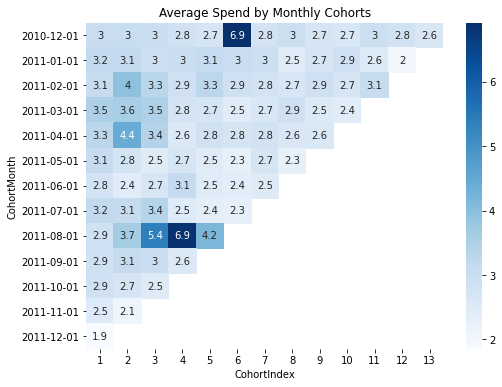

In [10]:
# Import seaborn package as sns
import seaborn as sns

# Initialize an 8 by 6 inches plot figure
plt.figure(figsize=(8, 6))

# Add a title
plt.title('Average Spend by Monthly Cohorts')
average_price.index = average_price.index.strftime('%Y-%m-%d')
# Create the heatmap
sns.heatmap(average_price, annot=True, cmap='Blues')
plt.show()

## Recency, Frequency, Monetary Value analysis

What is RFM segmentation?

Behavioral customer segmentation based on three metrics:
- Recency (R)
- Frequency (F)
- Monetary Value (M)

Definitions
- Recency - days since last customer transaction
- Frequency - number of transactions in the last 12 months
- Monetary Value - total spend in the last 12 months

Grouping RFM values

The RFM values can be grouped in several ways:

- Percentiles e.g. quantiles
- Pareto 80/20 cut
- Custom - based on business knowledge

We are going to implement percentile-based grouping.

Short review of percentiles

Process of calculating percentiles:
1. Sort customers based on that metric
2. Break customers into a pre-defined number of groups of equal size
3. Assign a label to each group

Calculate Spend quartiles (q=4)

We have created a dataset for you with random CustomerID and Spend values as data. You will now use this dataset to group customers into quartiles based on Spend values and assign labels to each of them. 

In [11]:
import random

data = pd.DataFrame()
data['CustomerID'] = list(range(7))
data['Spend'] = random.sample(range(100, 301), 7)

# Create a spend quartile with 4 groups - a range between 1 and 5
spend_quartile = pd.qcut(data['Spend'], q=4, labels=range(1,5))

# Assign the quartile values to the Spend_Quartile column in data
data['Spend_Quartile'] = spend_quartile

# Print data with sorted Spend values
print(data.sort_values('Spend'))

   CustomerID  Spend Spend_Quartile
3           3    120              1
2           2    146              1
4           4    151              2
1           1    193              2
0           0    248              3
5           5    260              4
6           6    268              4


Calculate Recency deciles (q=4)

In [12]:
data = pd.DataFrame()
data['CustomerID'] = list(range(7))
data['Recency_Days'] = random.sample(range(100, 301), 7)

# Store labels from 4 to 1 in a decreasing order
r_labels = list(range(4, 0, -1))

# Create a spend quartile with 4 groups and pass the previously created labels 
recency_quartiles = pd.qcut(data['Recency_Days'], q=4, labels=r_labels)

# Assign the quartile values to the Recency_Quartile column in `data`
data['Recency_Quartile'] = recency_quartiles 

# Print `data` with sorted Recency_Days values
print(data.sort_values('Recency_Days'))

   CustomerID  Recency_Days Recency_Quartile
2           2           140                4
3           3           155                4
0           0           167                3
6           6           194                3
1           1           213                2
5           5           268                1
4           4           275                1


Calculate RFM values

Calculate Recency, Frequency and Monetary values for the online dataset we have used before - it has been loaded for you with recent 12 months of data. There's a TotalSum column in the online dataset which has been calculated by multiplying Quantity and UnitPrice: online['Quantity'] * online['UnitPrice'].

Also, we have created a snapshot_date variable that you can use to calculate recency. Feel free to print the online dataset and the snapshot_date into the Console. The pandas library is loaded as pd, and datetime as dt.

In [13]:
!wget https://assets.datacamp.com/production/repositories/3202/datasets/9c670a495912949de0166c3ce690bad536ccf621/chapter_2.zip

--2020-06-10 02:36:36--  https://assets.datacamp.com/production/repositories/3202/datasets/9c670a495912949de0166c3ce690bad536ccf621/chapter_2.zip
Resolving assets.datacamp.com (assets.datacamp.com)... 13.226.46.129, 13.226.46.10, 13.226.46.98, ...
Connecting to assets.datacamp.com (assets.datacamp.com)|13.226.46.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1928414 (1.8M)
Saving to: ‘chapter_2.zip.1’

chapter_2.zip.1     100%[===================>]   1.84M  11.5MB/s    in 0.2s    

2020-06-10 02:36:37 (11.5 MB/s) - ‘chapter_2.zip.1’ saved [1928414/1928414]



In [27]:
# load data
# ['online12M.csv', '__MACOSX/', '__MACOSX/._online12M.csv', 'datamart_rfm.csv', '__MACOSX/._datamart_rfm.csv', 'datamart_rfm_scores_named_segment.csv', '__MACOSX/._datamart_rfm_scores_named_segment.csv', 'datamart_rfm_and_scores.csv', '__MACOSX/._datamart_rfm_and_scores.csv']


zf = zipfile.ZipFile('chapter_2.zip') 
online = pd.read_csv(zf.open('online12M.csv'), index_col=0)
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25,2.10,14286,United Kingdom
482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20,1.45,16360,United Kingdom
263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14,3.75,13933,United Kingdom
495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23,2.10,17290,United Kingdom
204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25,5.95,17663,United Kingdom


In [28]:
import datetime

online['InvoiceDate'] = pd.to_datetime(online['InvoiceDate'])
online['TotalSum'] = online['Quantity'] * online['UnitPrice']
snapshot_date = max(online.InvoiceDate) + datetime.timedelta(days=1)

# Calculate Recency, Frequency and Monetary value for each customer 
datamart = online.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})

# Rename the columns 
datamart.rename(columns={'InvoiceDate': 'Recency',
                         'InvoiceNo': 'Frequency',
                         'TotalSum': 'MonetaryValue'}, inplace=True)

# Print top 5 rows
print(datamart.head())

            Recency  Frequency  MonetaryValue
CustomerID                                   
12747             3         25         948.70
12748             1        888        7046.16
12749             4         37         813.45
12820             4         17         268.02
12822            71          9         146.15


Calculate 3 groups for Recency and Frequency

You will now group the customers into three separate groups based on Recency, and Frequency.

The dataset has been loaded as datamart, you can use console to view top rows of it. Also, pandas has been loaded as pd.

We will use the result from the exercise in the next one, where you will group customers based on the MonetaryValue and finally calculate and RFM_Score.

Once completed, print the results to the screen to make sure you have successfully created the quartile columns.

In [0]:
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 5)

# Assign these labels to three equal percentile groups 
r_groups = pd.qcut(datamart['Recency'], q=4, labels=r_labels)

# Assign these labels to three equal percentile groups 
f_groups = pd.qcut(datamart['Frequency'], q=4, labels=f_labels)

# Create new columns R and F
datamart = datamart.assign(R=r_groups.values, F=f_groups.values)

Calculate RFM Score

Great work, you will now finish the job by assigning customers to three groups based on the MonetaryValue percentiles and then calculate an RFM_Score which is a sum of the R, F, and M values.

The datamart has been loaded with the R and F values you have created in the previous exercise.

In [30]:
# Create labels for MonetaryValue 
m_labels = range(1, 5)

# Assign these labels to three equal percentile groups
m_groups = pd.qcut(datamart['MonetaryValue'], q=4, labels=m_labels)

# Create new column M
datamart = datamart.assign(M=m_groups.values)

# Calculate RFM_Score
datamart['RFM_Score'] = datamart[['R','F','M']].sum(axis=1)
print(datamart['RFM_Score'].head())

CustomerID
12747    12.0
12748    12.0
12749    12.0
12820    10.0
12822     7.0
Name: RFM_Score, dtype: float64


Creating custom segments

It's your turn to create a custom segmentation based on RFM_Score values. You will create a function to build segmentation and then assign it to each customer.

The dataset with the RFM values, RFM Segment and Score has been loaded as datamart, together with pandas and numpy libraries. Feel free to explore the data in the console.

In [31]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 10:
        return 'Top'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 10)):
        return 'Middle'
    else:
        return 'Low'

# Create a new variable RFM_Level
datamart['RFM_Level'] = datamart.apply(rfm_level, axis=1)

# Print the header with the top 5 rows to the console.
print(datamart.head())

            Recency  Frequency  MonetaryValue  R  F  M  RFM_Score RFM_Level
CustomerID                                                                 
12747             3         25         948.70  4  4  4       12.0       Top
12748             1        888        7046.16  4  4  4       12.0       Top
12749             4         37         813.45  4  4  4       12.0       Top
12820             4         17         268.02  4  3  3       10.0       Top
12822            71          9         146.15  2  2  3        7.0    Middle


Analyzing custom segments

As a final step, you will analyze average values of Recency, Frequency and MonetaryValue for the custom segments you've created. 

In [32]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = datamart.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
  
  	# Return the size of each segment
    'MonetaryValue': ['mean', 'count']
}).round(1)

# Print the aggregated dataset
print(rfm_level_agg)

          Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Level                                      
Low         180.8       3.2          52.7  1075
Middle       73.9      10.7         202.9  1547
Top          20.3      47.1         959.7  1021


## Data pre-processing for clustering

Advantages of k-means clustering
- One of the most popular unsupervised learning method
- Simple and fast
- Works well*

 with certain assumptions about the data

Key k-means assumptions
- Symmetric distribution of variables (not skewed)
- Variables with same average values
- Variables with same variance

Skewed variables
- Left-skewed
- Right-skewed
- Skew removed with logarithmic transformation

In [34]:
!wget https://assets.datacamp.com/production/repositories/3202/datasets/cc496bdfda1d59a462bf7ff3e4117bcd34c76b35/chapter_3.zip

--2020-06-10 03:56:29--  https://assets.datacamp.com/production/repositories/3202/datasets/cc496bdfda1d59a462bf7ff3e4117bcd34c76b35/chapter_3.zip
Resolving assets.datacamp.com (assets.datacamp.com)... 13.226.46.10, 13.226.46.129, 13.226.46.98, ...
Connecting to assets.datacamp.com (assets.datacamp.com)|13.226.46.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100465 (98K)
Saving to: ‘chapter_3.zip’

chapter_3.zip       100%[===================>]  98.11K  --.-KB/s    in 0.05s   

2020-06-10 03:56:29 (1.99 MB/s) - ‘chapter_3.zip’ saved [100465/100465]



In [44]:
# load data
# ['rfm_datamart.csv', 'datamart_normalized_df.csv']


zf = zipfile.ZipFile('chapter_3.zip') 
datamart_rfm = pd.read_csv(zf.open('rfm_datamart.csv'), index_col=0)
datamart_rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,3,25,948.70
12748,1,888,7046.16
12749,4,37,813.45
12820,4,17,268.02
12822,71,9,146.15


In [33]:
# Print the average values of the variables in the dataset
print(data.mean())

# Print the standard deviation of the variables in the dataset
print(data.std())

# Use `describe` function to get key statistics of the dataset
print(data.describe())

CustomerID            3.000000
Recency_Days        201.714286
Recency_Quartile      2.571429
dtype: float64
CustomerID           2.160247
Recency_Days        53.459375
Recency_Quartile     1.272418
dtype: float64
       CustomerID  Recency_Days
count    7.000000      7.000000
mean     3.000000    201.714286
std      2.160247     53.459375
min      0.000000    140.000000
25%      1.500000    161.000000
50%      3.000000    194.000000
75%      4.500000    240.500000
max      6.000000    275.000000


Identifying skewness

Visual analysis of the distribution

If it has a tail - it's skewed

Data transformations to manage skewness
- Logarithmic transformation (positive values only)

Dealing with negative values
- Adding a constant before log transformation
- Cube root transformation

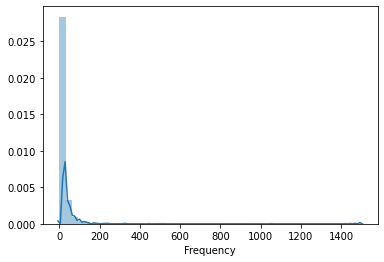

In [39]:
sns.distplot(datamart['Frequency'])

Manage skewness

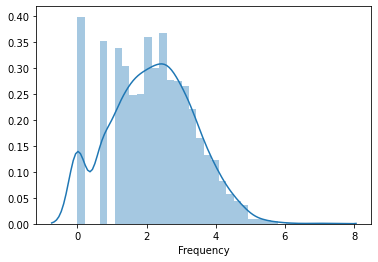

In [42]:
sns.distplot(np.log(datamart['Frequency']))

Centering and scaling variables

Identifying an issue
- Analyze key statistics of the dataset
- Compare mean and standard deviation

Centering variables with different means
- K-means works well on variables with the same mean
- Centering variables is done by subtracting average value from each observation
- Subtract mean and divide by standard deviation manually
- Or use a scaler from scikit-learn library (returns numpy.ndarray object)

In [45]:
datamart_rfm.describe()

,Recency,Frequency,MonetaryValue
count,3643.00000,3643.000000,3643.000000
mean,90.43563,18.714247,370.694387
std,94.44651,43.754468,1347.443451
min,1.00000,1.000000,0.650000
25%,19.00000,4.000000,58.705000
50%,51.00000,9.000000,136.370000
75%,139.00000,21.000000,334.350000
max,365.00000,1497.000000,48060.350000


Center and scale manually

In [46]:
# Center the data by subtracting average values from each entry
data_centered = datamart_rfm - datamart_rfm.mean()

# Scale the data by dividing each entry by standard deviation
data_scaled = datamart_rfm / datamart_rfm.std()

# Normalize the data by applying both centering and scaling
data_normalized = (datamart_rfm - datamart_rfm.mean()) / datamart_rfm.std()

# Print summary statistics to make sure average is zero and standard deviation is one
print(data_normalized.describe().round(2))

       Recency  Frequency  MonetaryValue
count  3643.00    3643.00        3643.00
mean     -0.00      -0.00           0.00
std       1.00       1.00           1.00
min      -0.95      -0.40          -0.27
25%      -0.76      -0.34          -0.23
50%      -0.42      -0.22          -0.17
75%       0.51       0.05          -0.03
max       2.91      33.79          35.39


Center and scale with StandardScaler()

In [57]:
from sklearn.preprocessing import StandardScaler

# Initialize a scaler
scaler = StandardScaler()

# Fit the scaler
scaler.fit(datamart_rfm)

# Scale and center the data
data_normalized = scaler.transform(datamart_rfm)

# Create a pandas DataFrame
data_normalized = pd.DataFrame(data_normalized, index=datamart_rfm.index, columns=datamart_rfm.columns)

# Print summary statistics
print(data_normalized.describe().round(2))

       Recency  Frequency  MonetaryValue
count  3643.00    3643.00        3643.00
mean      0.00       0.00           0.00
std       1.00       1.00           1.00
min      -0.95      -0.40          -0.27
25%      -0.76      -0.34          -0.23
50%      -0.42      -0.22          -0.17
75%       0.51       0.05          -0.03
max       2.91      33.79          35.40


Sequence of structuring pre-processing steps

Why the sequence matters?
- Log transformation only works with positive data
- Normalization forces data to have negative values and log will not work

Sequence
1. Unskew the data - log transformation
2. Standardize to the same average values
3. Scale to the same standard deviation
4. Store as a separate array to be used for clustering

Visualize RFM distributions

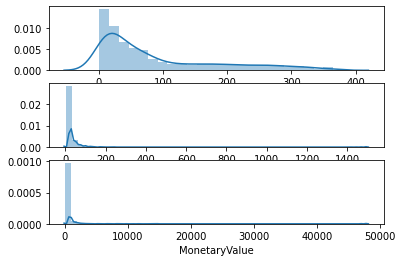

In [49]:
# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(datamart_rfm['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(datamart_rfm['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(datamart_rfm['MonetaryValue'])

# Show the plot
plt.show()

Pre-process RFM data

In [0]:
# Unskew the data
datamart_log = np.log(datamart_rfm)

# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(datamart_log)

# Scale and center the data
datamart_normalized = scaler.transform(datamart_log)

# Create a pandas DataFrame
datamart_normalized = pd.DataFrame(data=datamart_normalized, index=datamart_rfm.index, columns=datamart_rfm.columns)

Visualize the normalized variables

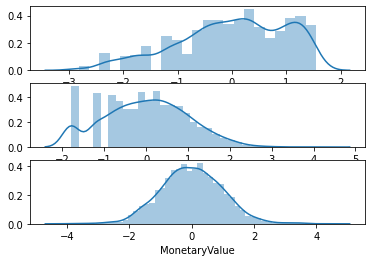

In [51]:
# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(datamart_normalized['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(datamart_normalized['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(datamart_normalized['MonetaryValue'])

# Show the plot
plt.show()

## Customer Segmentation with K-means

Key steps
- Data pre-processing
- Choosing a number of clusters
- Running k-means clustering on pre-processed data
- Analyzing average RFM values of each cluster

Methods to define the number of clusters
- Visual methods - elbow criterion
- Mathematical methods - silhouette coefficient
- Experimentation and interpretation

Running k-means
- Import KMeans from sklearn library and initialize it as kmeans
- Compute k-means clustering on pre-processed data
- Extract cluster labels from labels_ attribute

Run KMeans

In [0]:
# Import KMeans 
from sklearn.cluster import KMeans

# Initialize KMeans
kmeans = KMeans(n_clusters=3, random_state=0) 

# Fit k-means clustering on the normalized data set
kmeans.fit(datamart_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

Assign labels to raw data

In [72]:
# Create a DataFrame by adding a new cluster label column
datamart_rfm_k3 = datamart_rfm.assign(Cluster=cluster_labels)

# Group the data by cluster
grouped = datamart_rfm_k3.groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         164.8       3.1          53.5  1176
1          77.1      12.6         219.2  1578
2          15.7      50.3        1059.3   889

Choosing number of clusters

Methods
- Visual methods - elbow criterion
- Mathematical methods - silhouette coefficient
- Experimentation and interpretation

Elbow criterion method
- Plot the number of clusters against within-cluster sum-of-squared-errors (SSE) -
sum of squared distances from every data point to their cluster center
- Identify an "elbow" in the plot
- Elbow - a point representing an "optimal" number of clusters

Using elbow criterion method
-  Best to choose the point on elbow, or the next point
- Use as a guide but test multiple solutions
- Elbow plot built on datamart_rfm

Experimental approach - analyze segments
- Build clustering at and around elbow solution
- Analyze their properties - average RFM values
- Compare against each other and choose one which makes most business sense

Calculate sum of squared errors

In [0]:
sse = {}
# Fit KMeans and calculate SSE for each k
for k in range(1, 21):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=0)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(data_normalized)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_ 

Plot sum of squared errors

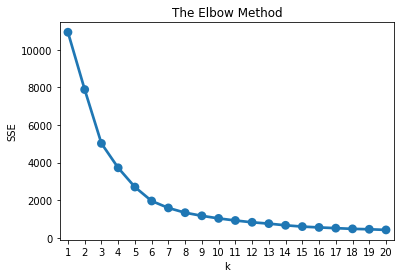

In [76]:
# Add the plot title "The Elbow Method"
plt.title('The Elbow Method')

# Add X-axis label "k"
plt.xlabel('k')

# Add Y-axis label "SSE"
plt.ylabel('SSE')

# Plot SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

Approaches to build customer personas
- Summary statistics for each cluster e.g. average RFM values
- Snake plots (from market research
- Relative importance of cluster attributes compared to population

Summary statistics of each cluster
- Run k-means segmentation for several k values around the recommended value.
- Create a cluster label column in the original DataFrame
- Calculate average RFM values and sizes for each cluster
- Compare average RFM values of each clustering solution

Snake plots to understand and compare segments
- Market research technique to compare different segments
- Visual representation of each segment's attributes
- Need to first normalize data (center & scale)
- Plot each cluster's average normalized values of each attribute

Relative importance of segment attributes
- Useful technique to identify relative importance of each segment's attribute
- Calculate average values of each cluster
- Calculate average values of population
- Calculate importance score by dividing them and subtracting 1 (ensures 0 is returned when cluster average equals population average)

Analyze and plot relative importance
- The further a ratio is from 0, the more important that attribute is for a segment relative to the total population.
- Plot a heatmap for easier interpretation

Prepare data for the snake plot

In [0]:
datamart_normalized = datamart_normalized.assign(Cluster=cluster_labels)

# Melt the normalized dataset and reset the index
datamart_melt = pd.melt(
  					datamart_normalized.reset_index(), 
                        
# Assign CustomerID and Cluster as ID variables                  
                    id_vars=['CustomerID', 'Cluster'],

# Assign RFM values as value variables
                    value_vars=['Recency', 'Frequency', 'MonetaryValue'], 
                        
# Name the variable and value
                    var_name='Metric', value_name='Value'
					)

In [92]:
datamart_melt

,CustomerID,Cluster,Metric,Value
0,12747,2,Recency,-2.002111
1,12748,2,Recency,-2.814389
2,12749,2,Recency,-1.789408
3,12820,2,Recency,-1.789408
4,12822,1,Recency,0.337299
...,...,...,...,...
10924,18280,0,MonetaryValue,-0.975767
10925,18281,0,MonetaryValue,-1.125576
10926,18282,0,MonetaryValue,-1.152432
10927,18283,2,MonetaryValue,0.866383


Visualize snake plot

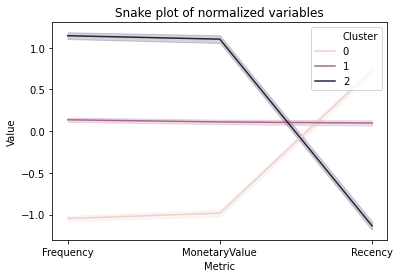

In [78]:
# Add the plot title
plt.title('Snake plot of normalized variables')

# Add the x axis label
plt.xlabel('Metric')

# Add the y axis label
plt.ylabel('Value')

# Plot a line for each value of the cluster variable
sns.lineplot(data=datamart_melt, x='Metric', y='Value', hue='Cluster')
plt.show()

Calculate relative importance of each attribute

In [94]:
# Calculate average RFM values for each cluster
cluster_avg = datamart_rfm_k3.groupby(['Cluster']).mean() 

# Calculate average RFM values for the total customer population
population_avg = datamart_rfm.mean()

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg - 1

# Print relative importance score rounded to 2 decimals
print(relative_imp.round(2))

         Recency  Frequency  MonetaryValue
Cluster                                   
0           0.82      -0.84          -0.86
1          -0.15      -0.33          -0.41
2          -0.83       1.69           1.86


Plot relative importance heatmap

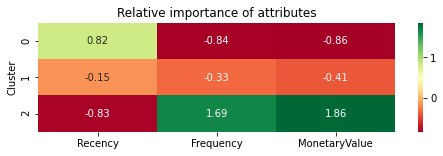

In [95]:
# Initialize a plot with a figure size of 8 by 2 inches 
plt.figure(figsize=(8, 2))

# Add the plot title
plt.title('Relative importance of attributes')

# Plot the heatmap
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

Key steps of the segmentation project
- Gather data - updated data with an additional variable
- Pre-process the data
- Explore the data and decide on the number of clusters
- Run k-means clustering
- Analyze and visualize results

Updated RFM data
- Same RFM values plus additional Tenure variable
- Tenure - time since the first transaction
- Defines how long the customer has been with the company

Goals for this project
- Remember key pre-processing rules
- Apply data exploration techniques
- Practice running several k-means iterations
- Analyze results quantitatively and visually

In [96]:
!wget https://assets.datacamp.com/production/repositories/3202/datasets/eb6a32ed7e5faa4c4b237ab8afb94df55bb4b3a5/chapter_4.zip

--2020-06-10 06:14:37--  https://assets.datacamp.com/production/repositories/3202/datasets/eb6a32ed7e5faa4c4b237ab8afb94df55bb4b3a5/chapter_4.zip
Resolving assets.datacamp.com (assets.datacamp.com)... 13.226.46.129, 13.226.46.120, 13.226.46.98, ...
Connecting to assets.datacamp.com (assets.datacamp.com)|13.226.46.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 260395 (254K)
Saving to: ‘chapter_4.zip’

chapter_4.zip       100%[===================>] 254.29K  --.-KB/s    in 0.09s   

2020-06-10 06:14:38 (2.90 MB/s) - ‘chapter_4.zip’ saved [260395/260395]



In [98]:
# load data
# ['dummy_data.csv', 'datamart_rfmt.csv', 'cluster_labels_rfm_k3.csv', 'datamart_normalized_df.csv', 'datamart_melt.csv', 'cluster_labels_rfmt_k4.csv']



zf = zipfile.ZipFile('chapter_4.zip') 
datamart_rfmt = pd.read_csv(zf.open('datamart_rfmt.csv'), index_col=0)
datamart_rfmt.head()

,Recency,Frequency,MonetaryValue,Tenure
CustomerID,,,,
12747,3,25,948.70,362
12748,1,888,7046.16,365
12749,4,37,813.45,214
12820,4,17,268.02,327
12822,71,9,146.15,88


Pre-process data

In [0]:
# Import StandardScaler 
from sklearn.preprocessing import StandardScaler

# Apply log transformation
datamart_rfmt_log = np.log(datamart_rfmt)

# Initialize StandardScaler
scaler = StandardScaler(); scaler.fit(datamart_rfmt_log)

# Transform and store the scaled data as datamart_rfmt_normalized
datamart_rfmt_normalized = scaler.transform(datamart_rfmt_log)

Calculate and plot sum of squared errors

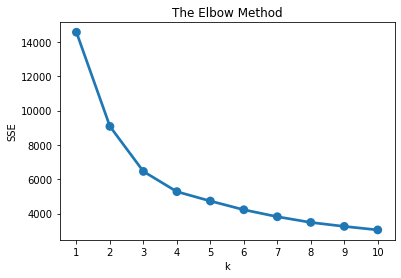

In [101]:
sse={}
# Fit KMeans and calculate SSE for each k
for k in range(1, 11):
  
    # Initialize KMeans with k clusters and fit it 
    kmeans = KMeans(n_clusters=k, random_state=1).fit(datamart_rfmt_normalized)
    
    # Assign sum of squared distances to k element of the sse dictionary
    sse[k] = kmeans.inertia_ 

# Add the plot title, x and y axis labels
plt.title('The Elbow Method'); plt.xlabel('k'); plt.ylabel('SSE')

# Plot SSE values for each k stored as keys in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

Build 4-cluster solution

In [0]:
# Import KMeans 
from sklearn.cluster import KMeans

# Initialize KMeans
kmeans = KMeans(n_clusters=4, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(datamart_rfmt_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_

Analyze the segments

In [103]:
# Create a new DataFrame by adding a cluster label column to datamart_rfmt
datamart_rfmt_k4 = datamart_rfmt.assign(Cluster=cluster_labels)

# Group by cluster
grouped = datamart_rfmt_k4.groupby(['Cluster'])

# Calculate average RFMT values and segment sizes for each cluster
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean',
    'Tenure': ['mean', 'count']
  }).round(1)

Recency Frequency MonetaryValue Tenure      
           mean      mean          mean   mean count
Cluster                                             
0         203.6       3.3          58.6  221.9   923
1          13.0      54.3        1151.6  279.9   761
2          88.2      15.2         283.5  247.8  1215
3          32.8       7.2         101.6   44.9   744